# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

_author: Adrish Maity, Sachin Malusare_

In [1]:
import numpy as np
import os
# from scipy.misc import imread, imresize
from imageio import imread
import datetime
import os
import cv2
import matplotlib.pyplot as plt
from skimage import transform as trf

We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.set_random_seed(30)

Using TensorFlow backend.


In [3]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout, LSTM
from keras.layers.convolutional import Conv2D, MaxPooling2D, Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.applications import ResNet50, mobilenet
from keras import optimizers
from keras.regularizers import l2

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [4]:
PATH = "Project_data"

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [5]:
class BuildGeneratorForTraining():
    
    def normalize_image(self, image):
        return image/255
    
    def get_random_image_augmentation(self, image):
        dx = np.random.randint(-30, 30)
        dy = np.random.randint(-30, 30)
    #     print(dx, dy)
        M = np.float32([[1, 0, dx], [0, 1, dy]])

        augmented_image = cv2.warpAffine(image, M, (image.shape[1], image.shape[0]))

        gray = cv2.cvtColor(augmented_image,cv2.COLOR_BGR2GRAY)
        x0, y0 = np.argwhere(gray > 0).min(axis=0)
        x1, y1 = np.argwhere(gray > 0).max(axis=0) 
        
        cropped=augmented_image[x0:x1,y0:y1,:]
        
        image_resized=cv2.resize(cropped,(self.height, self.width), interpolation=cv2.INTER_AREA)

        # normalize the image
        image_norm = self.normalize_image(image_resized)

        M_rotate = cv2.getRotationMatrix2D((self.height//2,self.width//2), np.random.randint(-10,10), 1.0)
        rotated = cv2.warpAffine(image_norm, M_rotate, (self.height,self.width))

        return rotated
    
    def load_data(self, folder):
        self.train_doc = np.random.permutation(open(folder + '/' + 'train.csv').readlines())
        self.val_doc = np.random.permutation(open(folder + '/' + 'val.csv').readlines())
        
        self.train_path = folder + '/' + 'train'
        self.val_path =  folder + '/' + 'val'
        
        self.num_train_sequences = len(self.train_doc)
        self.num_val_sequences = len(self.val_doc)
        
    def set_image_parameters(self, height=100, width=100):
        self.height=height
        self.width=width
        
        self.channels=3
        self.n_classes=5
        self.total_frames=30
    
    def generator(self, source_path, folder_list, is_augmentation=False):
        print( 'Source path = ', source_path, '; batch size =', self.batch_size)
        img_idx = np.round(np.linspace(0,self.total_frames-1,self.frames)).astype(int) #create a list of image numbers you want to use for a particular video
        
        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(t)//self.batch_size # calculate the number of batches
            for batch in range(num_batches): # we iterate over the number of batches
                
                batch_data = np.zeros((self.batch_size,len(img_idx),self.height,self.width,self.channels)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
                batch_labels = np.zeros((self.batch_size,5)) # batch_labels is the one hot representation of the output
                
                if (is_augmentation):
                    aug_batch_data = np.zeros((self.batch_size,len(img_idx),self.height,self.width,self.channels)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
                    flip_batch_data = np.zeros((self.batch_size,len(img_idx),self.height,self.width,self.channels))
                    flip_batch_labels = np.zeros((self.batch_size,5))
                    
                for folder in range(self.batch_size): # iterate over the batch_size
                    imgs = os.listdir(source_path+'/'+ t[folder + (batch*self.batch_size)].split(';')[0]) # read all the images in the folder
                    for idx,item in enumerate(img_idx): #  Iterate over the frames/images of a folder to read them in
                        image = imread(source_path+'/'+ t[folder + (batch*self.batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

                        #crop the images and resize them. Note that the images are of 2 different shape 
                        #and the conv3D will throw error if the inputs in a batch have different shapes
                        image_resized=cv2.resize(image,(self.height, self.width), interpolation=cv2.INTER_AREA)
                        
                        batch_data[folder,idx,:,:,0] = self.normalize_image(image_resized[:,:,0]) #normalise and feed in the image
                        batch_data[folder,idx,:,:,1] = self.normalize_image(image_resized[:,:,1]) #normalise and feed in the image
                        batch_data[folder,idx,:,:,2] = self.normalize_image(image_resized[:,:,2]) #normalise and feed in the image
                        
                        if (is_augmentation):
                            
                            # random affine transformation
                            aug_image = self.get_random_image_augmentation(image)
                            aug_batch_data[folder,idx,:,:,0] = aug_image[:,:,0] #normalise and feed in the image
                            aug_batch_data[folder,idx,:,:,1] = aug_image[:,:,1] #normalise and feed in the image
                            aug_batch_data[folder,idx,:,:,2] = aug_image[:,:,2] #normalise and feed in the image
                            
                            # horizontal flip
                            fliped = self.normalize_image(np.flip(image_resized, 1)) 
                            flip_batch_data[folder,idx,:,:,0] = fliped[:,:,0]
                            flip_batch_data[folder,idx,:,:,1] = fliped[:,:,1]
                            flip_batch_data[folder,idx,:,:,2] = fliped[:,:,2]

                    batch_labels[folder, int(t[folder + (batch*self.batch_size)].strip().split(';')[2])] = 1
                    if (is_augmentation):
                        # set batch label for horizontal flipped images
                        # right swipe becomes left swipe and viceversa (handling that)
                        if int(t[folder + (batch*self.batch_size)].strip().split(';')[2])==0:
                            flip_batch_labels[folder, 1] = 1
                        elif int(t[folder + (batch*self.batch_size)].strip().split(';')[2])==1:
                            flip_batch_labels[folder, 0] = 1
                        else:
                            flip_batch_labels[folder, int(t[folder + (batch*self.batch_size)].strip().split(';')[2])] = 1
                
                if (is_augmentation):
                    batch_data = np.append(batch_data, aug_batch_data, axis=0)
                    batch_labels = np.append(batch_labels, batch_labels, axis=0)
                
                yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do


            # write the code for the remaining data points which are left after full batches
            if (len(folder_list) != self.batch_size*num_batches):
                batch_size = len(folder_list) - (self.batch_size*num_batches)
                batch_data = np.zeros((batch_size,len(img_idx),self.height,self.width,self.channels)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
                batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
                
                if (is_augmentation):
                    aug_batch_data = np.zeros((batch_size,len(img_idx),self.height,self.width,self.channels)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
                    flip_batch_data = np.zeros((batch_size,len(img_idx),self.height,self.width,self.channels))
                    flip_batch_labels = np.zeros((batch_size,5))

                for folder in range(batch_size): # iterate over the batch_size
                    imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0]) # read all the images in the folder
                    for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                        image = imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

                        #crop the images and resize them. Note that the images are of 2 different shape 
                        #and the conv3D will throw error if the inputs in a batch have different shapes
                        image_resized=cv2.resize(image,(self.height, self.width), interpolation=cv2.INTER_AREA)

                        batch_data[folder,idx,:,:,0] = self.normalize_image(image_resized[:,:,0]) #normalise and feed in the image
                        batch_data[folder,idx,:,:,1] = self.normalize_image(image_resized[:,:,1]) #normalise and feed in the image
                        batch_data[folder,idx,:,:,2] = self.normalize_image(image_resized[:,:,2]) #normalise and feed in the image
                        
                        if (is_augmentation):
                            
                            # random affine transformation
                            aug_image = self.get_random_image_augmentation(image)
                            aug_batch_data[folder,idx,:,:,0] = aug_image[:,:,0] #normalise and feed in the image
                            aug_batch_data[folder,idx,:,:,1] = aug_image[:,:,1] #normalise and feed in the image
                            aug_batch_data[folder,idx,:,:,2] = aug_image[:,:,2] #normalise and feed in the image
                            
                            # horizontal flip
                            fliped = self.normalize_image(np.flip(image_resized, 1)) #np.fliplr(norm_image)
                            flip_batch_data[folder,idx,:,:,0] = fliped[:,:,0]
                            flip_batch_data[folder,idx,:,:,1] = fliped[:,:,1]
                            flip_batch_data[folder,idx,:,:,2] = fliped[:,:,2]

                    batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1
                    if (is_augmentation):
                        # set batch label for horizontal flipped images
                        # right swipe becomes left swipe and viceversa (handling that)
                        if int(t[folder + (num_batches*batch_size)].strip().split(';')[2])==0:
                            flip_batch_labels[folder, 1] = 1
                        elif int(t[folder + (num_batches*batch_size)].strip().split(';')[2])==1:
                            flip_batch_labels[folder, 0] = 1
                        else:
                            flip_batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1
                
                if (is_augmentation):
                    batch_data = np.append(batch_data, aug_batch_data, axis=0)
                    batch_data = np.append(batch_data, flip_batch_data, axis=0)
                    
                    batch_labels = np.append(batch_labels, batch_labels, axis=0)
                    batch_labels = np.append(batch_labels, flip_batch_labels, axis=0)
                    
                yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do
    
    
    def set_training_parameters(self, frames=30, batch_size=20, num_epochs=20):
        self.frames=frames
        self.batch_size=batch_size
        self.num_epochs=num_epochs

    
    def train_model(self, model, is_augmentation=False, saved_model_location=""):
        train_gen = self.generator(self.train_path, self.train_doc,is_augmentation=is_augmentation) #, is_flip=is_flip)
        val_gen = self.generator(self.val_path, self.val_doc)

        model_name = saved_model_location+'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
    
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        
        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'
        
        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
            
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, cooldown=1, verbose=1) 
        
        callbacks_list = [checkpoint, LR]

        if (self.num_train_sequences%self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

        if (self.num_val_sequences%self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences/self.batch_size)
        else:
            validation_steps = (self.num_val_sequences//self.batch_size) + 1
        
        history=model.fit_generator(train_gen, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1, 
                                callbacks=callbacks_list, validation_data=val_gen, 
                                validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)            
        return history


In [6]:
def plot_model_parameters_over_epoch(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,5))
    # Loss Curves
    axes[0].plot(history.history['loss'],'r',linewidth=3.0)
    axes[0].plot(history.history['val_loss'],'b',linewidth=3.0)
    axes[0].legend(['Training loss', 'Validation Loss'],fontsize=8)
    axes[0].set_xlabel('Epochs',fontsize=16)
    axes[0].set_ylabel('Loss',fontsize=16)

    # Accuracy Curves
    axes[1].plot(history.history['categorical_accuracy'],'r',linewidth=3.0)
    axes[1].plot(history.history['val_categorical_accuracy'],'b',linewidth=3.0)
    axes[1].legend(['Training Accuracy', 'Validation Accuracy'],fontsize=8)
    axes[1].set_xlabel('Epochs ',fontsize=16)
    axes[1].set_ylabel('Accuracy',fontsize=16)
    
    plt.show()

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

# Training the entire dataset using Base Model defined

### Defining 2D convolution Transfer Learning + RNN (LSTM) model 

- using mobilenet architecture (few layers trainable)

In [17]:
class Conv2D_Transfer_RNN_3(BuildGeneratorForTraining):
        
    def initiate_model(self, lstm_layer=64, dense_layer=128, dropout=0.25, lr=0.001):
        
        #Input
        rnn_input_shape = (self.frames,self.height,self.width,self.channels)
        
        mobilenet_trf = mobilenet.MobileNet(weights='imagenet', include_top=False)
        
        #freeze first 80 layers in base model
        for layer in mobilenet_trf.layers[:80]:
            # un-freeze the BatchNorm layers
            if "BatchNormalization" in layer.__class__.__name__:
                layer.trainable = True
            else:
                layer.trainable = False
        
        
        # initialize the model
        model = Sequential()
        
        # add the pretrained layer
        model.add(TimeDistributed(mobilenet_trf,input_shape=rnn_input_shape))
        
        # apply batch normalization
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(Flatten()))    
        
        ## less memory consumption and faster operation
        model.add(LSTM(lstm_layer, kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01)))
        
        # apply dropout
        model.add(Dropout(dropout))

        # fully connected layer 1
        model.add(Dense(dense_layer,activation='relu', kernel_regularizer=l2(0.01)))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))
        
        # fully connected layer 2
        model.add(Dense(dense_layer,activation='relu', kernel_regularizer=l2(0.01)))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))
        
        # output layer
        model.add(Dense(self.n_classes, activation='softmax'))
        optimizer = optimizers.Adam(lr=lr)
        model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        
        return model

## Model 10:
- using mobilenet (transfer learning) + RNN (LSTM)
- Image Size: `(100,100)`
- Frames: `16`
- Batch Size: `10`
- Epoch: `25`
- with augmentation

In [18]:
# initialize the model object
model_conv2d_tran_RNN_3=Conv2D_Transfer_RNN_3()

# load the data from folder 
model_conv2d_tran_RNN_3.load_data(PATH)

# set the image parameters
model_conv2d_tran_RNN_3.set_image_parameters(height=100,width=100)

# set the training parameter
model_conv2d_tran_RNN_3.set_training_parameters(frames=16,batch_size=10,num_epochs=25)

# get the model with default parameters
model_10=model_conv2d_tran_RNN_3.initiate_model()

model_10.summary()
print("Number of Params in the model:", model_10.count_params())

# train the model with default parameter with augmentation
history = model_conv2d_tran_RNN_3.train_model(model_10, is_augmentation=True)


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/keras_applications/mobilenet.py:206: UserWarning: MobileNet shape is undefined. Weights for input shape (224, 224) will be loaded.
  warnings.warn('MobileNet shape is undefined.'


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_9 (TimeDist (None, 16, 3, 3, 1024)    3228864   
_________________________________________________________________
time_distributed_10 (TimeDis (None, 16, 3, 3, 1024)    4096      
_________________________________________________________________
time_distributed_11 (TimeDis (None, 16, 1, 1, 1024)    0         
_________________________________________________________________
time_distributed_12 (TimeDis (None, 16, 1024)          0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                278784    
_________________________________________________________________
dropout_7 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)               8320      
__________

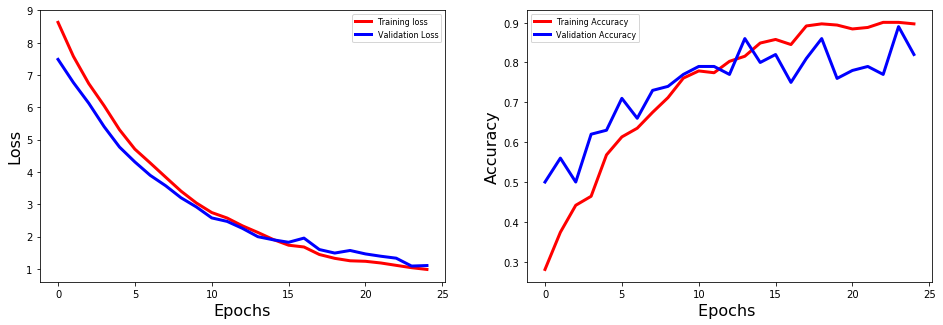

In [19]:
# plot the training history of the model
plot_model_parameters_over_epoch(history)

The model achieved maximum validation accuracy of `89%` and corresponding training accuracy is `90%`

The number of parameters in the model: `3,538,245`
Trainable parameters: `1,386,501`

Model memorry footprint: `25.5 MB`

# Final Model

## Model 10: Transfer Learning using MobileNet and LSTM gives us the best result keeping the model parameters and model size in mind.